In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# # for google colab, had to reinstall some pacakges.

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import folium
from esda.moran import Moran
from esda.getisord import G_Local
from esda.getisord import G_Local
from libpysal.weights import Queen
from libpysal.weights import Queen
import scipy
from folium import Marker
from IPython.display import IFrame
import plotly.express as px
from google.colab import files

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data source:

file_path = '/content/drive/My Drive/X999/evictions_df_cleaned.csv'

In [ ]:
evictions_df_raw = pd.read_csv(file_path)

In [ ]:
evictions_df = evictions_df_raw.copy()

In [ ]:
evictions_df.head()

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,-74.011883,7.0,38.0,118.0,3143881.0,3.057940e+09,Sunset Park East
1,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,40.640008,-74.017068,7.0,38.0,122.0,3143435.0,3.057820e+09,Sunset Park West
2,*53336/16,170279,3400 PAUL AVENUE,15D,2018-10-17,BRONX,10468,Not an Ejectment,Possession,40.877190,-73.889569,7.0,11.0,409.0,2015444.0,2.032510e+09,Van Cortlandt Village
3,*5990/17,2703,480 CONCORD AVENUE,4E,2019-08-30,BRONX,10455,Not an Ejectment,Possession,40.811197,-73.908810,1.0,8.0,35.0,2003900.0,2.025770e+09,Mott Haven-Port Morris
4,000098/17,69483,65 EAST 193RD ST,1B,2017-05-04,BRONX,10468,Not an Ejectment,Possession,40.866075,-73.896515,7.0,14.0,401.0,2013945.0,2.031770e+09,Bedford Park-Fordham North


In [ ]:
evictions_df.columns, \
evictions_df.shape

(Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta'],
       dtype='object'),
 (76484, 17))

In [ ]:
evictions_df.executed_date = pd.to_datetime(evictions_df.executed_date)

In [ ]:
evictions_df.executed_date.min(), evictions_df.executed_date.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2024-09-16 00:00:00'))

## To properly understand the geo features and find hot spots in this evcition datasets, we need to utilize the GeoDataFrame to see if there is any interesting patterns that could be attributed to Societal trends/Predatory landlord bahaviors/corporate landlord behaviors

In [ ]:
# first, we create a GeoDataFrame
evictions_gdf = gpd.GeoDataFrame(
    evictions_df,
    geometry=gpd.points_from_xy(evictions_df['longitude'], evictions_df['latitude'])
)

In [ ]:
evictions_gdf.head()

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,geometry
0,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,-74.011883,7.0,38.0,118.0,3143881.0,3.057940e+09,Sunset Park East,POINT (-74.01188 40.63594)
1,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,40.640008,-74.017068,7.0,38.0,122.0,3143435.0,3.057820e+09,Sunset Park West,POINT (-74.01707 40.64001)
2,*53336/16,170279,3400 PAUL AVENUE,15D,2018-10-17,BRONX,10468,Not an Ejectment,Possession,40.877190,-73.889569,7.0,11.0,409.0,2015444.0,2.032510e+09,Van Cortlandt Village,POINT (-73.88957 40.87719)
3,*5990/17,2703,480 CONCORD AVENUE,4E,2019-08-30,BRONX,10455,Not an Ejectment,Possession,40.811197,-73.908810,1.0,8.0,35.0,2003900.0,2.025770e+09,Mott Haven-Port Morris,POINT (-73.90881 40.8112)
4,000098/17,69483,65 EAST 193RD ST,1B,2017-05-04,BRONX,10468,Not an Ejectment,Possession,40.866075,-73.896515,7.0,14.0,401.0,2013945.0,2.031770e+09,Bedford Park-Fordham North,POINT (-73.89652 40.86608)


In [ ]:
# secondly, create a map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

In [ ]:
nyc_map

# folium could generate better maps, but it does not load with the data points on my mac

In [ ]:
# add eviction points to the map
# does not really generatet the map
for idx, row in evictions_gdf.iterrows():
    folium.Marker([row['latitude'], row['longitude']],
                  popup=row['borough']).add_to(nyc_map)

# nyc_map

In [ ]:
!pip install plotly


In [ ]:
evictions_cleaned = evictions_gdf.dropna(subset=['latitude', 'longitude'])
evictions_cleaned = evictions_cleaned.reset_index(drop=True)

In [ ]:
# # a basic version
# fig = px.scatter_geo(evictions_cleaned,
#                      lat='latitude', lon='longitude',
#                      hover_name='borough',
#                      title="NYC Evictions Map")

# fig.update_geos(scope='usa', fitbounds="locations")
# fig.show()


In [ ]:
# a better version with boroughs in different colors
fig = px.scatter_geo(evictions_cleaned,
                     lat='latitude', lon='longitude',
                     # add color to make it look better
                     color='borough',
                     hover_name='borough',
                     title="NYC Evictions Map")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [ ]:
fig.write_html("nyc_evictions_map_plotly.html")
files.download("nyc_evictions_map_plotly.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
coords = evictions_gdf[['latitude', 'longitude']].values
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
evictions_gdf['cluster'] = db.labels_
num_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print(num_clusters)

6


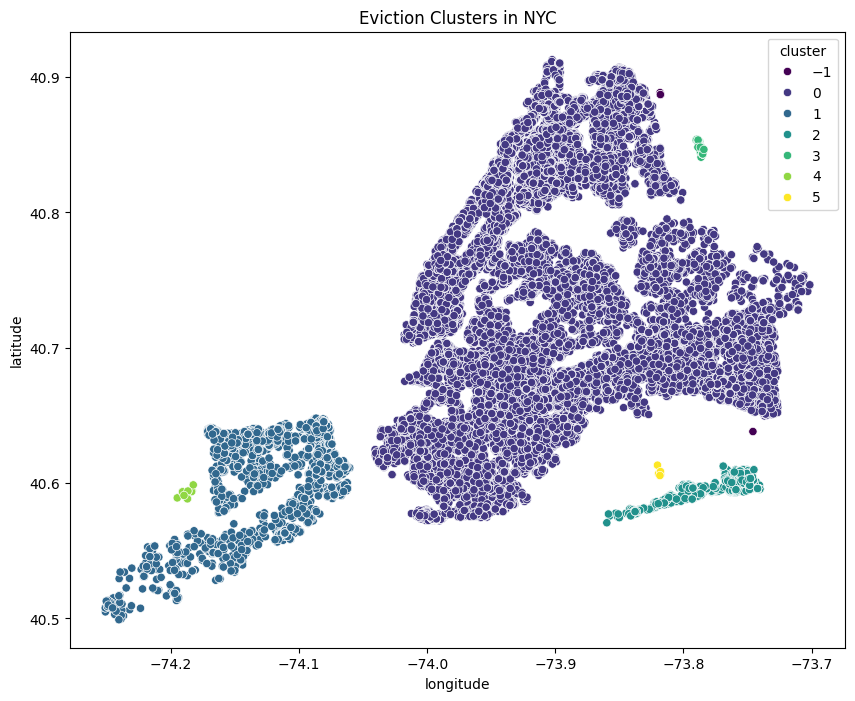

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=evictions_gdf, x='longitude', y='latitude', hue='cluster', palette='viridis')
plt.title("Eviction Clusters in NYC")
plt.show()

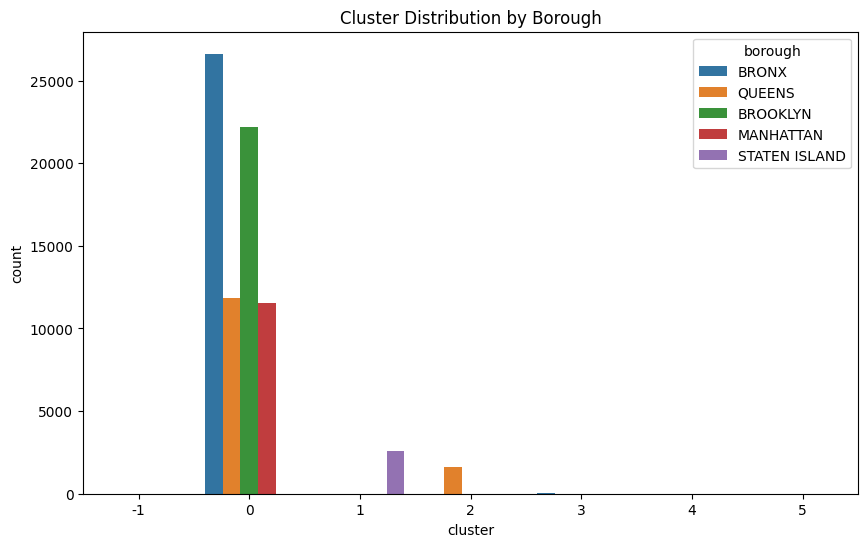

In [ ]:
# how clusters are distributed by borough?
cluster_distribution = evictions_gdf.groupby(['borough', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.countplot(data=evictions_gdf, x='cluster', hue='borough')
plt.title('Cluster Distribution by Borough')
plt.show()

In [ ]:
print(cluster_distribution)

          borough  cluster  count
0           BRONX       -1      4
1           BRONX        0  26624
2           BRONX        3     31
3        BROOKLYN        0  22184
4       MANHATTAN        0  11570
5          QUEENS       -1      1
6          QUEENS        0  11868
7          QUEENS        2   1607
8          QUEENS        5      5
9   STATEN ISLAND        1   2577
10  STATEN ISLAND        4     13


In [ ]:
# just in case
evictions_gdf['latitude'] = pd.to_numeric(evictions_gdf['latitude'], errors='coerce')
evictions_gdf['longitude'] = pd.to_numeric(evictions_gdf['longitude'], errors='coerce')

In [ ]:
print(evictions_gdf.isna().sum())
evictions_gdf = evictions_gdf.dropna(subset=['latitude', 'longitude'])

court_index_number           0
docket_number                0
eviction_address             0
eviction_apartment_number    0
executed_date                0
borough                      0
eviction_postcode            0
ejectment                    0
eviction/legal_possession    0
latitude                     0
longitude                    0
community_board              0
council_district             0
census_tract                 0
bin                          0
bbl                          0
nta                          0
geometry                     0
cluster                      0
dtype: int64


In [1]:
# # check for nans
# print(evictions_gdf.isna().sum())
# evictions_gdf = evictions_gdf.dropna(subset=['latitude', 'longitude'])

In [ ]:
evictions_gdf['eviction/legal_possession'].unique()

['Possession' 'Eviction']


In [ ]:
# print(evictions_gdf['eviction/legal_possession'].unique())


In [ ]:
evictions_gdf['eviction/legal_possession'] = pd.to_numeric(evictions_gdf['eviction/legal_possession'], errors='coerce')
evictions_gdf['eviction/legal_possession'].isna().sum()


76484


In [ ]:
# Encode categorical values as numeric
evictions_gdf['eviction/legal_possession_encoded'] = pd.factorize(evictions_gdf['eviction/legal_possession'])[0]


In [ ]:
# Drop rows with NaN values in the relevant column (if necessary)
evictions_gdf = evictions_gdf.dropna(subset=['eviction/legal_possession_encoded'])


In [ ]:
# Ensure the column is numeric
evictions_gdf['eviction/legal_possession_encoded'] = pd.to_numeric(evictions_gdf['eviction/legal_possession_encoded'], errors='coerce')
evictions_gdf = evictions_gdf.dropna(subset=['eviction/legal_possession_encoded'])
evictions_gdf['eviction/legal_possession_encoded'] = evictions_gdf['eviction/legal_possession_encoded'].astype('float64')


In [ ]:
hotspot = G_Local(evictions_gdf['eviction/legal_possession_encoded'], w, n_jobs=1)


In [ ]:
hotspot

In [ ]:
# prepare spatial weights
w = Queen.from_dataframe(evictions_gdf)

In [ ]:
# # perform local Getis-Ord Gi* analysis
# hotspot = G_Local(evictions_gdf['eviction/legal_possession_encoded'], w)

In [ ]:
# add the z-scores (hotspot results) to the GeoDataFrame
evictions_gdf['hotspot_z_scores'] = hotspot.Zs

count    76484.0
mean        -1.0
std          0.0
min         -1.0
25%         -1.0
50%         -1.0
75%         -1.0
max         -1.0
Name: eviction/legal_possession_encoded, dtype: float64


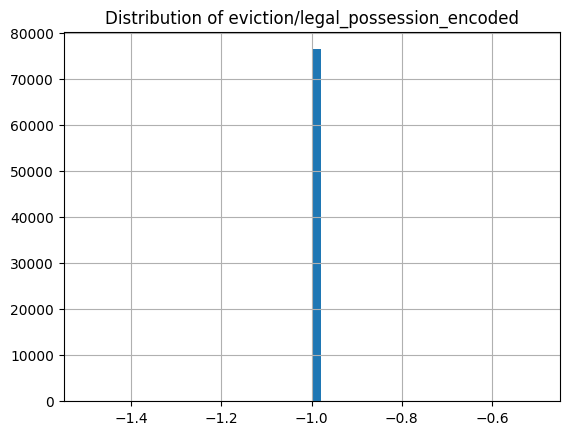

In [ ]:
# handle inf and -inf z-score:
# not working yet
# check for outliers in the encoded eviction column
print(evictions_gdf['eviction/legal_possession_encoded'].describe())

# using a histogram to visualize the distribution
evictions_gdf['eviction/legal_possession_encoded'].hist(bins=50)
plt.title("Distribution of eviction/legal_possession_encoded")
plt.show()

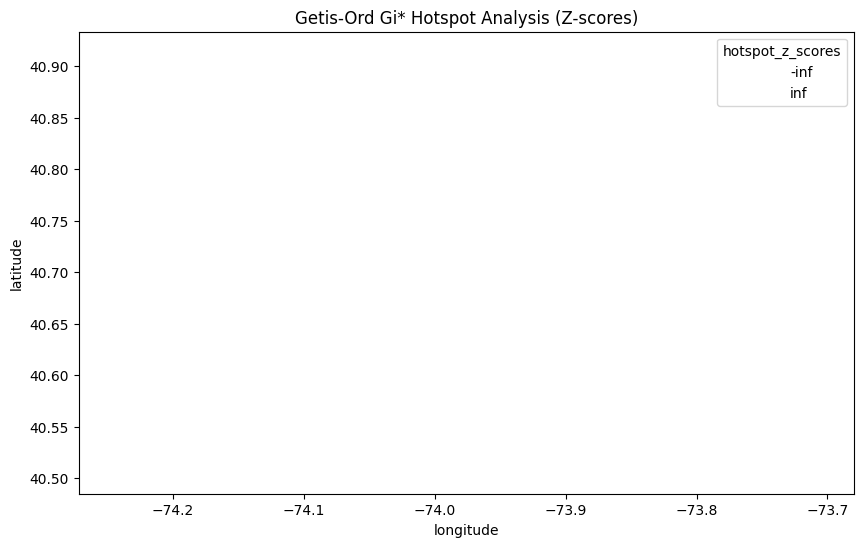

In [ ]:
# plot the hotspots using z-scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=evictions_gdf, x='longitude', y='latitude', hue='hotspot_z_scores', palette='coolwarm')
plt.title('Getis-Ord Gi* Hotspot Analysis (Z-scores)')
plt.show()